# Data Science project: CIRI

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import tqdm
import os

from enum import Enum
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Parameters

In [2]:
# Whether model descriptors should be extracted for the baseline (True), or
# loaded from the filesystem (False)
extract_model_descriptors = False

## Generic setup

Set the device. Using CUDA on CUDA-enabled devices speeds up the use of convolutional networks significantly.

In [3]:
cuda_enabled = torch.cuda.is_available()
device = torch.device("cuda:1" if cuda_enabled else "cpu")

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [4]:
rng = np.random.default_rng(0)

We create the descriptors through transfer learning. We remove the last fully-connected (classification) layers of pre-trained models and use the output of the convolutional part of the respective model as descriptors. We do this for:

- VGG16

These models were chosen because of ... **TODO: List reasons for choosing models**

## Load datasets

Because the images were pre-processed in another notebook, they must now be loaded into this one. To do so, we use a custom class taken from https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658.

In [ ]:
class prepped_data(Dataset):
    def __init__(self, img, mask):
        self.img = img  #img path
        self.mask = mask  #mask path
        self.len = len(os.listdir(self.img))

    def __getitem__(self, index):
        ls_img = sorted(os.listdir(self.img))
        ls_mask = sorted(os.listdir(self.mask))

        img_file_path = os.path.join(self.img, ls_img[index])
        img_tensor = torch.load(img_file_path)

        mask_file_path = os.path.join(self.mask, ls_mask[index])
        mask_tensor = torch.load(mask_file_path)

        return img_tensor, mask_tensor

    def __len__(self):
        return self.len

In [ ]:
data_train = prepped_data('./content/train_loader/img', './content/train_loader/target')
data_test = prepped_data('./content/test_loader/img', './content/test_loader/target')

targets_train = [target for (_, target) in data_train]
targets_test = [target for (_, target) in data_test]

dataloader_train = DataLoader(data_train, batch_size=4, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=4, shuffle=False)

with open('./content/data_classes.bin', 'rb') as file:
    data_classes = pickle.load(file)

In [8]:
class DataType(Enum):
    TRAIN = "train"
    TEST = "test"

class Dataset:
    """
    Represents a dataset from which data, targets and dataloaders can be easily
    extracted. Used mostly as a Data Transfer Object to reduce the need to pass
    high numbers of parameters.
    """

    def __init__(self, data, ratios):
        """
        Keyword arguments:
        data   -- torch Dataset
        ratios -- labels mapped to the portion of the dataset the corresponding
                  subset should entail
        """
        self.all_data = data
        self.all_targets = self._get_targets(data)
        self.all_classes = data.classes

        data_splits = torch.utils.data.random_split(data,
                                                    list(ratios.values()),
                                                    generator=torch.Generator().manual_seed(42))
        labels = ratios.keys()

        self.data = {}
        for i, label in enumerate(labels):
            self.data[label] = data_splits[i]

        self.targets = {}
        for label, data in self.data.items():
            self.targets[label] = self._get_targets(data)

        self.dataloaders = {}
        for label, data in self.data.items():
            self.dataloaders[label] = DataLoader(data, batch_size=4, shuffle=False)

    def _get_targets(self, data):
        return [target for (_, target) in data]


dataset = Dataset(data, {DataType.TRAIN: 0.7, DataType.TEST: 0.3})

/home/jovyan/2022-1B-DS-CIRI-Project/env/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Initialize models

In [13]:
class Model():
    """
    Represents a generic convolutional model that is used for transfer
    learning, from which descriptors can be extracted for classification.
    """
    def __init__(self, model, name):
        self.model = model
        self.name = name

        for param in self.model.parameters():
            # As the model will not be trained, gradients are not required.
            # Disabling them speeds up performance.
            param.requires_grad = False

        self.model.eval()
        self.remove_classifier()

    def remove_classifier(self):
        """
        Removes the last fully connected layer (the classifier) from the
        model, allowing the extraction of descriptors.
        """
        raise NotImplementedError()

    def to(self, device):
        self.model = self.model.to(device)

    def descriptors(self, dataloader, as_numpy=True):
        """
        Returns the output of the model for all items in the dataloader.
        """
        outputs = []
        with torch.no_grad():
            for data, targets in tqdm.tqdm(dataloader):
                data = data.to(device)
                output = self.model(data).detach()
                outputs.extend(output)

        if as_numpy:
            outputs = np.array([output.cpu().numpy() for output in outputs])

        return outputs


models = []
if cuda_enabled:
    torch.cuda.empty_cache()

### VGG16

In [14]:
class Vgg16Model(Model):
    def __init__(self):
        model = torchvision.models.vgg16(weights="DEFAULT")
        super().__init__(model, "VGG16")

    def remove_classifier(self):
        self.model.classifier = nn.Identity()


vgg16 = Vgg16Model()
vgg16.to(device)

models.append(vgg16)

### Inception V3

In [15]:
class InceptionV3Model(Model):
    def __init__(self):
        model = torchvision.models.inception_v3(weights="DEFAULT")
        super().__init__(model, "InceptionV3")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


inception = InceptionV3Model()
inception.to(device)

models.append(inception)

## Baseline

### Obtain image descriptors

In [16]:
class DescriptorManager:
    """
    Handles the loading, saving and extraction of data descriptors.
    """
    
    def __init__(self, base_path="./data/descriptors", extract=False):
        self.base_path = base_path
        self.extract = extract

    def create_path(self, model_name, label):
        """
        Creates a standardised path for descriptors with the provided model name
        and label to prevent inconsistencies between loading and saving descriptors.
        """
        return f"{self.base_path}/{model_name}/descriptors_{label}.bin"

    def safe_open_wb(self, path):
        """
        Open "path" for writing, creating any parent directories as needed.
        """
        os.makedirs(os.path.dirname(path), exist_ok=True)

        return open(path, 'wb')

    def save_descriptors(self, descriptors, model_name, label):
        """
        Saves the provided descriptor to the file system at a path derived from
        the model name and label.
        """
        path = self.create_path(model_name, label)
        with self.safe_open_wb(path) as file:
            pickle.dump(descriptors, file)

    def extract_save_descriptors(self, dataloader, model, label):
        """
        Extracts descriptors from the provided model and saves them to the
        file system.
        """
        descriptors = model.descriptors(dataloader, True)
        self.save_descriptors(descriptors, model.name, label)

        return descriptors

    def load_descriptors(self, model_name, label):
        """
        Loads and returns the provided descriptors from the file system, based
        on the provided model name and label.
        """
        path = self.create_path(model_name, label)
        with open(path, "rb") as file:
            return pickle.load(file)

    def get_descriptors(self, dataloader, model, label):
        """
        Returns descriptors from the file system or extracts them from the model,
        depending on the DescriptorManager "extract" property. Loading from the
        file system relies on the provided model.name andlabel.
        """
        if self.extract:
            return self.extract_save_descriptors(dataloader, model, label)

        return self.load_descriptors(model.name, label)


descriptor_manager = DescriptorManager(extract=extract_model_descriptors)

### Perform k-nearest neighbors (kNN) classification

First, we define the number of neighbors using which we would like to perform classification.

In [17]:
n_neighbors_list = [2, 3, 5, 8, 13]

For each `n_neighbors` in the defined list, we perform classification and calculate the accuracy.

In [18]:
class DescriptorAssessor:
    def __init__(self, model, descriptor_manager):
        self.model = model
        self.descriptor_manager = descriptor_manager

    def _print_accuracies(self, accuracies, label):
        for n_neighbors, accuracy in accuracies.items():
            print(f"{self.model.name} accuracy on {label} set for {n_neighbors}-neighbor classification: {accuracy}")

    def _plot_accuracies(self, ax, accuracies, label):
        return ax.plot(
            accuracies.keys(),
            list(accuracies.values()),
            label=label,
            marker="o"
        )

    def _get_descriptors(self, dataset, data_types):
        descriptors = {}

        for data_type in data_types:
            descriptors[data_type] = self.descriptor_manager.get_descriptors(
                dataset.dataloaders[data_type],
                self.model,
                data_type
            )

        return descriptors

    def assess(self, dataset, n_neighbors_list, train_type, assess_types):
        """
        Assess the performance of kNN-classifiers on model descriptors for
        different numbers of neighbors.

        Keyword arguments:
        dataset -- dictionary of data types (train, test, ...) mapped to Subsets
        n_neighbors_list -- list of numbers of neighbors to assess
        train_type -- the data type to which the classifier should be fit
        assess_types -- the types on which to assess the classifier accuracy
        """
        descriptors = self._get_descriptors(
            dataset,
            assess_types
        )

        predictions = dict([(assess_type, {}) for assess_type in assess_types])
        accuracies = dict([(assess_type, {}) for assess_type in assess_types])

        for n_neighbors in n_neighbors_list:
            classifier = KNeighborsClassifier(n_neighbors=n_neighbors).fit(
                descriptors[train_type],
                dataset.targets[train_type]
            )

            for assess_type in assess_types:
                predictions[assess_type][n_neighbors] = classifier.predict(
                    descriptors[assess_type]
                )
                accuracies[assess_type][n_neighbors] = accuracy_score(
                    dataset.targets[assess_type],
                    predictions[assess_type][n_neighbors]
                )

        return (descriptors, predictions, accuracies)

    def visualise(self, predictions, accuracies):
        fig, ax = plt.subplots()
        for assess_type, assess_type_accuracies in accuracies.items():
            self._print_accuracies(assess_type_accuracies, assess_type)
            self._plot_accuracies(ax, assess_type_accuracies, assess_type)

        ax.legend()
        ax.set_title(f"kNN-classification performance using {self.model.name} descriptors")
        ax.set_xlabel("k (number of neighbours)")
        ax.set_ylabel("accuracy")
        plt.show()

In [19]:
descriptor_assessor = DescriptorAssessor(vgg16, descriptor_manager)
descriptors, predictions, accuracies = descriptor_assessor.assess(
    dataset,
    n_neighbors_list,
    DataType.TRAIN, 
    [DataType.TRAIN, DataType.TEST]
)

VGG16 accuracy on DataType.TRAIN set for 2-neighbor classification: 0.4566440349175558
VGG16 accuracy on DataType.TRAIN set for 3-neighbor classification: 0.3743937924345296
VGG16 accuracy on DataType.TRAIN set for 5-neighbor classification: 0.38254122211445196
VGG16 accuracy on DataType.TRAIN set for 8-neighbor classification: 0.32376333656644035
VGG16 accuracy on DataType.TRAIN set for 13-neighbor classification: 0.2649854510184287
VGG16 accuracy on DataType.TEST set for 2-neighbor classification: 0.11367753623188406
VGG16 accuracy on DataType.TEST set for 3-neighbor classification: 0.11775362318840579
VGG16 accuracy on DataType.TEST set for 5-neighbor classification: 0.11231884057971014
VGG16 accuracy on DataType.TEST set for 8-neighbor classification: 0.11548913043478261
VGG16 accuracy on DataType.TEST set for 13-neighbor classification: 0.11730072463768115


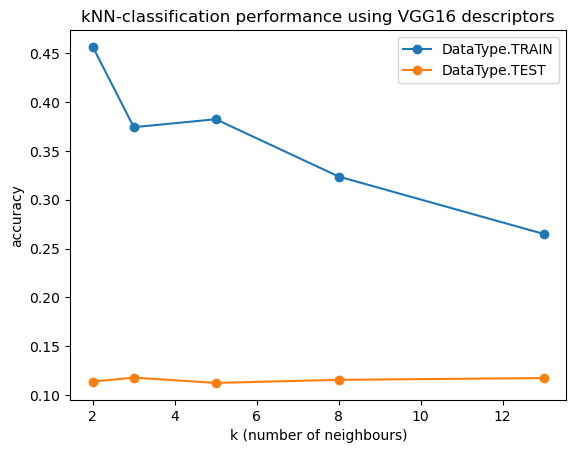

In [20]:
descriptor_assessor.visualise(predictions, accuracies)

### Visually assess predicted vs. target through PCA

In [21]:
best_n_train = max(accuracies[DataType.TRAIN], key=accuracies[DataType.TRAIN].get)
best_n_test = max(accuracies[DataType.TEST], key=accuracies[DataType.TEST].get)
print(best_n_train)
print(best_n_test)

2
3


In [22]:
pca_train = PCA(n_components=best_n_train).fit_transform(descriptors[DataType.TRAIN])
pca_test = PCA(n_components=best_n_test).fit_transform(descriptors[DataType.TEST])

In [23]:
def plot_predictions_against_targets(data,
                                     predictions,
                                     targets,
                                     n_classes,
                                     cmap=None):
    """Draws a scatter plot of two-dimensional data which highlights
    differences between targets and predictions through distinct edge and fill
    colors."""

    if cmap is None:
        cmap = plt.get_cmap("rainbow")

    if isinstance(targets, list):
        targets = np.array(targets)

    colors_target = cmap(targets / n_classes)
    colors_predictions = cmap(predictions / n_classes)

    fig, ax = plt.subplots()
    # Plot targets (ground truth) with fill color representing target class
    ax.scatter(data[:, 0],
               data[:, 1],
               facecolors=colors_target,
               label="target")

    # Plot predictions with edge color representing predicted class
    ax.scatter(data[:, 0],
               data[:, 1],
               facecolors="none",
               edgecolors=colors_predictions,
               label="predicted")

    legend = ax.legend()
    # Set colors to black to indicate the legend is about marker type, rather
    # than color
    legend.legendHandles[0].set_color("black")
    legend.legendHandles[1].set_edgecolor("black")

    return (fig, ax)

Text(0.5, 1.0, 'Two-component PCA, test data')

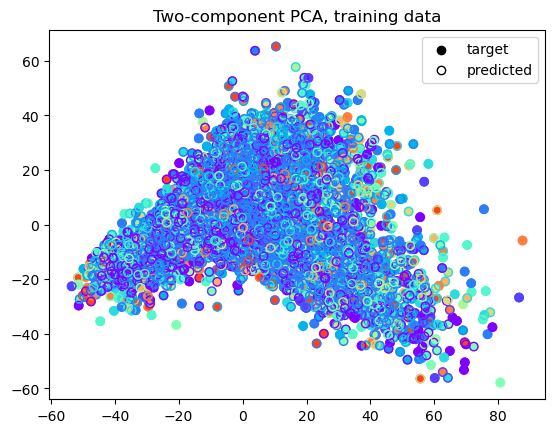

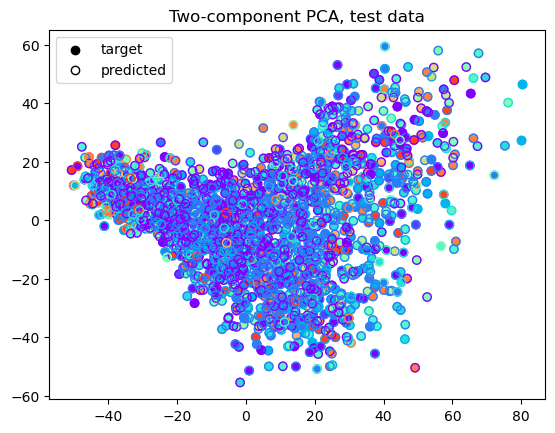

In [24]:
_, ax_train_scatter = plot_predictions_against_targets(pca_train,
                                                       predictions[DataType.TRAIN][best_n_train],
                                                       dataset.targets[DataType.TRAIN],
                                                       len(dataset.all_classes))
ax_train_scatter.set_title("Two-component PCA, training data")

_, ax_test_scatter = plot_predictions_against_targets(pca_test,
                                                      predictions[DataType.TEST][best_n_test],
                                                      dataset.targets[DataType.TEST],
                                                      len(dataset.all_classes))
ax_test_scatter.set_title("Two-component PCA, test data")